# Waiting time analysis

In [77]:
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

## Read logs

In [2]:
job_chars = pd.read_parquet('data/job_chars.parquet')
host_logs = pd.read_parquet("data/host_logs.parquet")

In [3]:
job_chars

,Batch_class,Submission_date,Waited,Start_date,Duration,Nodes,CPU,Memory,delta_CPU,delta_Memory
index,,,,,,,,,,
000030ecd19c9c04,feque,2020-02-18 11:14:38+01:00,29.916667,2020-02-18 11:44:33+01:00,1.450000,1.0,0.168851,0.31349,0.000000,0.000000
00020fcd04947084,clexpres,2020-05-30 11:50:05+02:00,5.383333,2020-05-30 11:55:28+02:00,4.700000,2.0,31.315993,2.02000,0.000000,0.000000
0002286e1d7e428d,clmedium,NaT,NaN,2020-09-28 07:55:47+02:00,60.716667,1.0,0.989072,0.04895,0.502306,0.005687
00024ec1bf68e413,clfo2,NaT,NaN,2020-06-29 01:05:19+02:00,0.116667,1.0,0.000000,0.00000,0.000000,0.000000
00027e89035bec8d,clmedium,2020-03-25 21:22:02+01:00,38.783333,2020-03-25 22:00:49+01:00,1.283333,1.0,21.721169,131.76000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
fffbfaccf8c9fbf4,clexpres,NaT,NaN,2020-03-27 15:05:44+01:00,5.033333,1.0,0.190265,0.11484,0.000000,0.000000
fffd086716a4d46c,cllong,NaT,NaN,2020-09-14 00:40:27+02:00,143.616667,1.0,0.994714,0.46693,0.025502,0.000300
ffff38341e8c6b3b,clmedium,2020-08-13 22:35:57+02:00,401.333333,2020-08-14 05:17:17+02:00,621.766667,8.0,31.858035,5.24000,0.662259,0.550000


In [4]:
host_logs

,Date,Free_CPUs,Free_Mem1,Used_CPUs,Cpu,Used_Mem1,ExecutionHost,QueueName,Free_Swap1,Used_Swap1,Load
0,2020-01-12 18:17:31,0,349.402344,32,32.0,33.308594,neshcl218,clbigmem,NaN,NaN,NaN
1,2020-01-12 18:17:31,0,302.101562,32,32.0,80.609375,neshcl219,clbigmem,NaN,NaN,NaN
2,2020-01-12 18:17:31,0,336.367188,32,31.5,46.343750,neshcl220,clbigmem,NaN,NaN,NaN
3,2020-01-12 18:17:31,0,378.503906,32,32.0,4.207031,neshcl221,clbigmem,NaN,NaN,NaN
4,2020-01-12 18:17:31,0,301.515625,32,32.0,81.195312,neshcl222,clbigmem,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6475638,2020-10-07 16:10:08,0,168.515625,32,31.6,22.195312,neshcl396,cllong,15.257812,0.000000,31.9
6475639,2020-10-07 16:10:08,0,79.578125,32,32.0,111.132812,neshcl397,cllong,14.609375,0.648438,32.0
6475640,2020-10-07 16:10:08,64,195.578125,0,0.0,571.132812,nesh-fe0-adm,feque,3.996094,0.000000,0.0
6475641,2020-10-07 16:10:08,60,747.976562,4,4.0,18.734375,nesh-fe1-adm,nan,2.585938,1.410156,4.0


In [5]:
detected_waiting_time = (job_chars['Waited'].notna() & job_chars['Waited']>0.0)

In [6]:
batch_classes = ['clexpres', 'clmedium', 'cllong', 'clbigmem', 'clfo2','feque']

In [12]:
host_logs = host_logs[host_logs['QueueName'].isin(batch_classes)]
host_logs = host_logs[host_logs['Free_CPUs']>0]
host_logs = host_logs[['Date','Free_CPUs','Free_Mem1','Used_CPUs','Used_Mem1','QueueName']]
host_logs

,Date,Free_CPUs,Free_Mem1,Used_CPUs,Used_Mem1,QueueName
111,2020-01-12 18:17:31,2,175.707031,30,15.003906,clmedium
112,2020-01-12 18:17:31,3,111.296875,21,16.597656,clfo2
113,2020-01-12 18:17:31,4,105.191406,20,22.703125,clfo2
114,2020-01-12 18:17:31,4,109.203125,20,18.691406,clfo2
115,2020-01-12 18:17:31,4,100.140625,20,27.753906,clfo2
...,...,...,...,...,...,...
6475622,2020-10-07 16:10:08,15,116.773438,17,73.937500,cllong
6475623,2020-10-07 16:10:08,28,186.167969,4,4.542969,cllong
6475628,2020-10-07 16:10:08,31,81.968750,1,108.742188,cllong
6475630,2020-10-07 16:10:08,31,128.128906,1,62.582031,cllong


In [13]:
jobs_waited = job_chars[detected_waiting_time]
jobs_waited = jobs_waited[['Batch_class','Submission_date','Waited','CPU','Memory']]

Manipulation of the datetime columns 

In [14]:
jobs_waited['Submission_date'] = jobs_waited['Submission_date'].dt.tz_convert('utc').dt.tz_localize(None)
jobs_waited 

,Batch_class,Submission_date,Waited,CPU,Memory
index,,,,,
000030ecd19c9c04,feque,2020-02-18 10:14:38,29.916667,0.168851,0.31349
00020fcd04947084,clexpres,2020-05-30 09:50:05,5.383333,31.315993,2.02000
00027e89035bec8d,clmedium,2020-03-25 20:22:02,38.783333,21.721169,131.76000
0003a37a7a8562f1,clexpres,2020-03-06 10:52:11,70.450000,NaN,NaN
00044e0a50d292e0,clmedium,2020-02-09 02:08:33,25.233333,29.034220,2.49000
...,...,...,...,...,...
fffabf82e38ce12d,clmedium,2020-03-11 13:13:06,1763.016667,31.920809,1.90000
fffb0eb6f2ab000b,clmedium,2020-09-20 15:14:20,757.650000,19.946999,15.33000
ffff38341e8c6b3b,clmedium,2020-08-13 20:35:57,401.333333,31.858035,5.24000


Adding `End_date` column based on the `Waited` and `Submission_date` column

In [15]:
jobs_waited['End_date'] = (jobs_waited['Submission_date'] + pd.to_timedelta(jobs_waited['Waited'], unit='m')).astype('datetime64[s]')

In [16]:
#cut very small Memory and CPU jobs as NaNs: 
nonzeros = (jobs_waited['CPU'] >=0.01)&(jobs_waited['Memory'] >=0.01)&(jobs_waited['CPU'].notna())&jobs_waited['Memory'].notna()

In [53]:
jobs_waited = jobs_waited[nonzeros]
jobs_waited = jobs_waited.sort_values('Submission_date')

<ipython-input-53-a0b8b48fd353>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  jobs_waited = jobs_waited[nonzeros]


In [18]:
#cut NaNs in Free_mem1 and Free_CPUs in host_logs
nonans = (host_logs['Free_CPUs'].notna())&(host_logs['Free_Mem1'].notna())
host_logs = host_logs[nonans]

Cutting hostlog data before the first logged job

In [28]:
start_date = jobs_waited['Submission_date'].min()
host_logs  = host_logs[host_logs['Date']>start_date]

In [45]:
len(jobs_waited)

42188

In [56]:
splitted_jobs  = []
splitted_hosts = []
n = np.arange(11)*4220
n[-1] = len(jobs_waited)

for i in range(10):
    split = jobs_waited.iloc[n[i]:n[i+1]]
    splitted_jobs.append(split)
    start = split['Submission_date'].min()
    end   = split['End_date'].max()
    split = host_logs[(host_logs['Date'] > start) & (host_logs['Date'] < end)]
    splitted_hosts.append(split)

In [59]:
y = 0
for split in splitted_hosts:
    y = y+len(split)
y

In [54]:
jobs_waited

,Batch_class,Submission_date,Waited,CPU,Memory,End_date
index,,,,,,
8e2c3d09f0a6aecf,clmedium,2020-02-06 19:03:48,567.683333,19.950777,15.35,2020-02-07 04:31:28
3fe9afee11b2eb7a,cllong,2020-02-06 19:03:48,1921.216667,19.945657,14.10,2020-02-08 03:05:01
962f66f60dc03aab,clmedium,2020-02-06 19:25:09,174.966667,31.809137,2.04,2020-02-06 22:20:07
83eddbb936e98c67,clmedium,2020-02-06 19:46:31,1801.266667,18.998504,15.34,2020-02-08 01:47:47
a80766a2c509391e,cllong,2020-02-06 19:46:31,4344.483333,31.910880,2.00,2020-02-09 20:10:59
...,...,...,...,...,...,...
c57264b584ed22fd,clexpres,2020-10-07 13:09:50,35.150000,29.285537,7.79,2020-10-07 13:44:59
f24f80f34924bd61,clexpres,2020-10-07 13:19:51,0.266667,20.729966,7.49,2020-10-07 13:20:07
6d0554fc54b46e19,clexpres,2020-10-07 13:29:52,3.566667,21.332792,7.40,2020-10-07 13:33:26


In [30]:
host_logs

,Date,Free_CPUs,Free_Mem1,Used_CPUs,Used_Mem1,QueueName
532533,2020-02-06 19:52:28,4,101.605469,20,26.289062,clfo2
532535,2020-02-06 19:52:28,3,111.355469,21,16.539062,clfo2
532538,2020-02-06 19:52:28,4,101.898438,20,25.996094,clfo2
532539,2020-02-06 19:52:28,4,103.082031,20,24.812500,clfo2
532540,2020-02-06 19:52:28,4,101.113281,20,26.781250,clfo2
...,...,...,...,...,...,...
6475622,2020-10-07 16:10:08,15,116.773438,17,73.937500,cllong
6475623,2020-10-07 16:10:08,28,186.167969,4,4.542969,cllong
6475628,2020-10-07 16:10:08,31,81.968750,1,108.742188,cllong
6475630,2020-10-07 16:10:08,31,128.128906,1,62.582031,cllong


In [65]:
indices = list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [62]:
def multiprocessing_worker(i):
    hosts = splitted_hosts[i]
    jobs  = splitted_jobs[i]
    n = len(jobs)
    mem_util = []
    cpu_util = []
    for j in range(n):
        hosts_while = hosts[
            (jobs.iloc[j]['Submission_date'] <= hosts['Date']) & (hosts['Date'] 
            <= jobs.iloc[j]['End_date']) & (hosts['QueueName'].str.contains(jobs.iloc[j]['Batch_class']))]
        Mem = hosts_while['Free_Mem1'].mean()/jobs.iloc[j]['Memory']
        CPU = hosts_while['Free_CPUs'].mean()/jobs.iloc[j]['CPU']
        mem_util.append(Mem)
        cpu_util.append(CPU)
    jobs['Mem_utilization'] = pd.Series(mem_util).values
    jobs['CPU_utilization'] = pd.Series(cpu_util).values
    return(jobs)

# Parallelize using multiprocessing

In [63]:
import multiprocessing

In [66]:
indices = list(range(10))

In [67]:
%%time
pool = multiprocessing.Pool(processes=10)
t = pool.map(multiprocessing_worker, indices)

<ipython-input-62-a14a91b7165a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs['Mem_utilization'] = pd.Series(mem_util).values
<ipython-input-62-a14a91b7165a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs['CPU_utilization'] = pd.Series(cpu_util).values
<ipython-input-62-a14a91b7165a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

CPU times: user 149 ms, sys: 186 ms, total: 335 ms
Wall time: 10min 23s


In [68]:
jobs_utilization = pd.concat(t, axis=0)

In [81]:
jobs_utilization

,Batch_class,Submission_date,Waited,CPU,Memory,End_date,Mem_utilization,CPU_utilization
index,,,,,,,,
8e2c3d09f0a6aecf,clmedium,2020-02-06 19:03:48,567.683333,19.950777,15.35,2020-02-07 04:31:28,10.580440,0.789678
3fe9afee11b2eb7a,cllong,2020-02-06 19:03:48,1921.216667,19.945657,14.10,2020-02-08 03:05:01,11.727911,0.776399
962f66f60dc03aab,clmedium,2020-02-06 19:25:09,174.966667,31.809137,2.04,2020-02-06 22:20:07,77.394293,0.440478
83eddbb936e98c67,clmedium,2020-02-06 19:46:31,1801.266667,18.998504,15.34,2020-02-08 01:47:47,10.560089,0.778152
a80766a2c509391e,cllong,2020-02-06 19:46:31,4344.483333,31.910880,2.00,2020-02-09 20:10:59,82.220649,0.506175
...,...,...,...,...,...,...,...,...
c57264b584ed22fd,clexpres,2020-10-07 13:09:50,35.150000,29.285537,7.79,2020-10-07 13:44:59,NaN,NaN
f24f80f34924bd61,clexpres,2020-10-07 13:19:51,0.266667,20.729966,7.49,2020-10-07 13:20:07,NaN,NaN
6d0554fc54b46e19,clexpres,2020-10-07 13:29:52,3.566667,21.332792,7.40,2020-10-07 13:33:26,NaN,NaN


In [ ]:
len(jobs_utilization[jobs_utilization['Mem_utilization'].notna()])

Write to parquet file:

In [78]:
tmp_data_path = Path("data/")

In [82]:
jobs_utilization.to_parquet(tmp_data_path / "jobs_utilization.parquet", compression="gzip")

In [16]:
def Scatter(df, x, batch_class):
    ax1 = df.loc[df['Batch_class'].str.contains(batch_class)].plot.scatter(x,'Waited',c='midnightblue')
    ax1.set_title(batch_class)
    ax1.set_ylabel('Waiting time in minutes')
    ax2 = ax1.twinx()
    mn, mx = ax1.get_ylim()
    ax2.set_ylim(mn/60, mx/60)
    ax2.set_ylabel('Waiting times in hours')

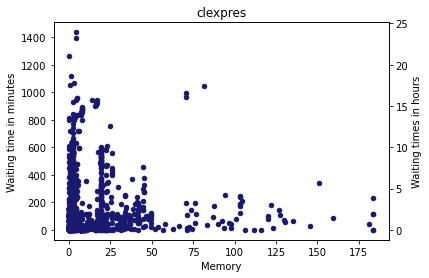

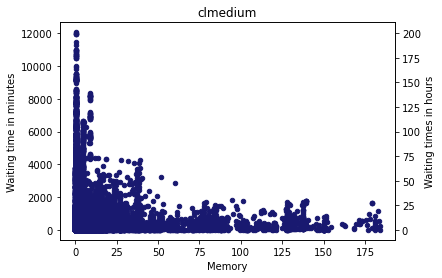

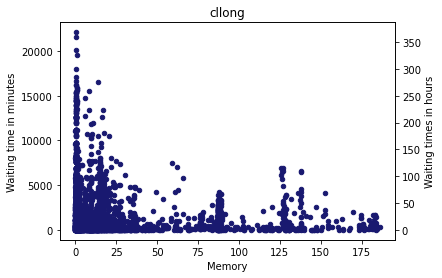

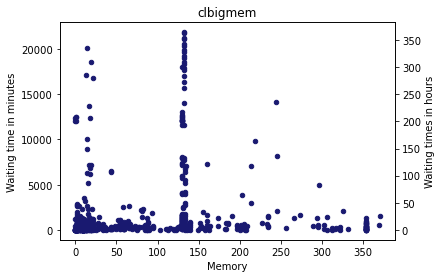

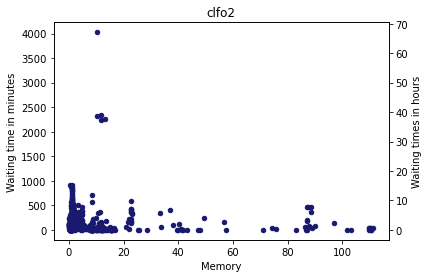

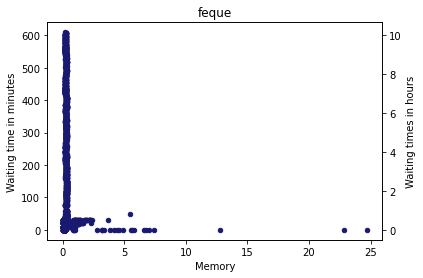

In [17]:
for batch_class in batch_classes:
    Scatter(jobs_waited,'Memory',batch_class)

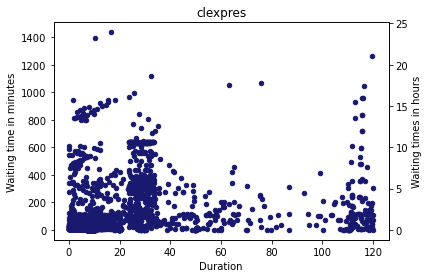

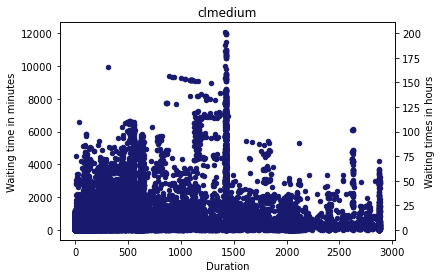

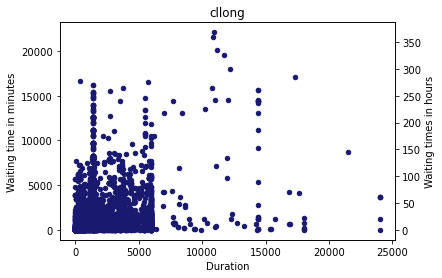

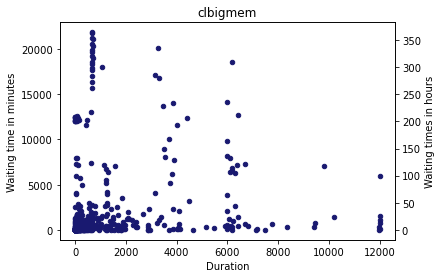

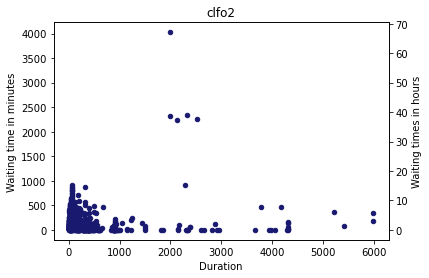

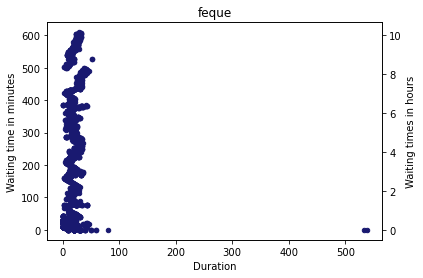

In [18]:
for batch_class in batch_classes:
    Scatter(jobs_waited,'Duration',batch_class)

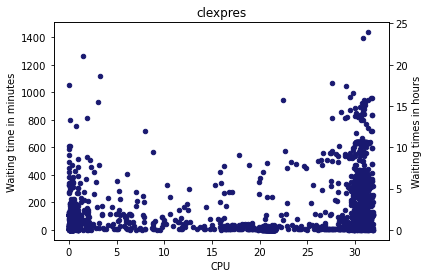

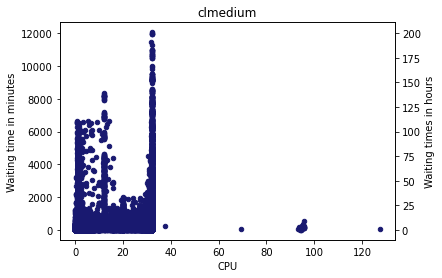

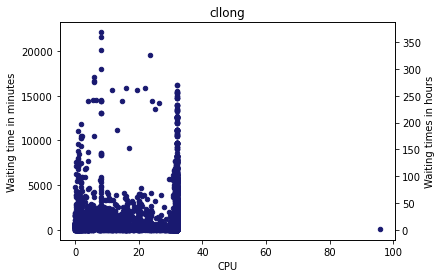

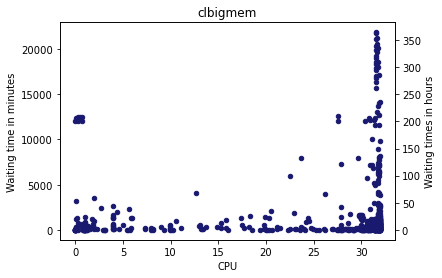

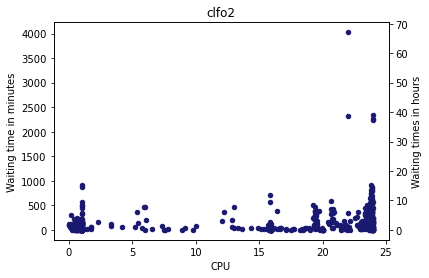

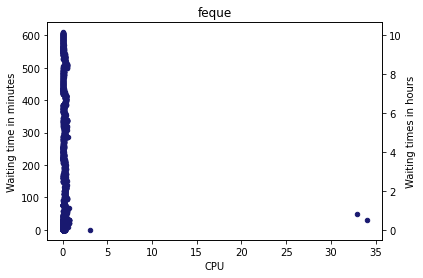

In [19]:
for batch_class in batch_classes:
    Scatter(jobs_waited,'CPU',batch_class)

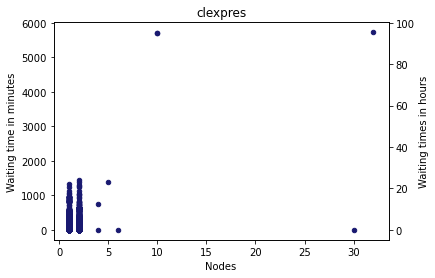

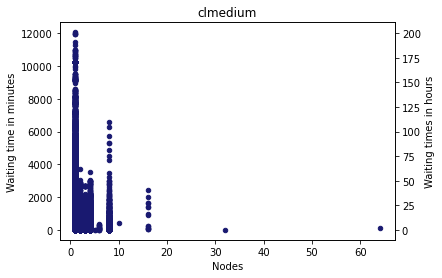

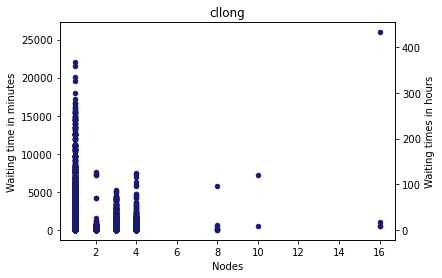

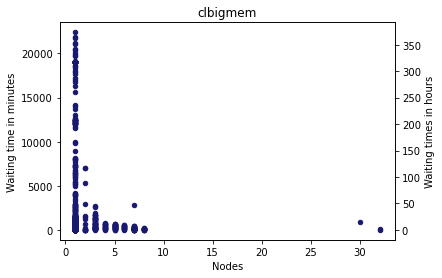

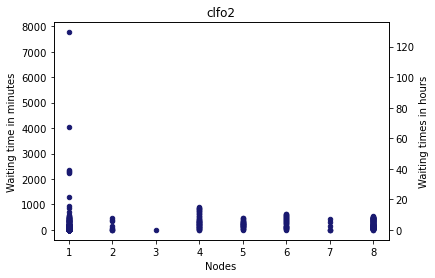

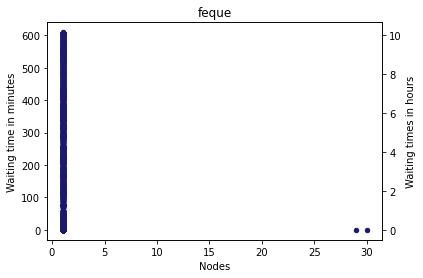

In [27]:
for batch_class in batch_classes:
    Scatter(jobs_waited,'Nodes',batch_class)

In [48]:
def Bin_plot(df, x, batch_class):
    ax1 = df.loc[df['Batch_class'].str.contains(batch_class)].plot.hexbin(x=x,y='Waited',bins='log')
    ax1.set_title(batch_class)
    ax1.set_ylabel('Waiting time in minutes')

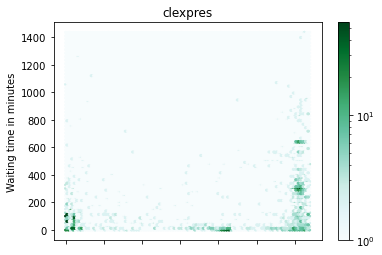

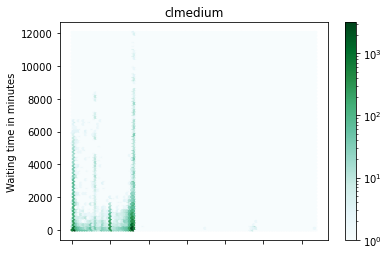

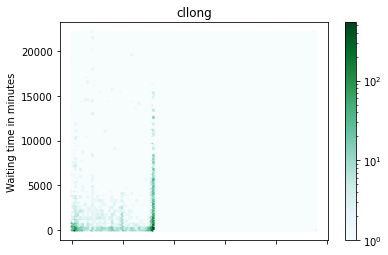

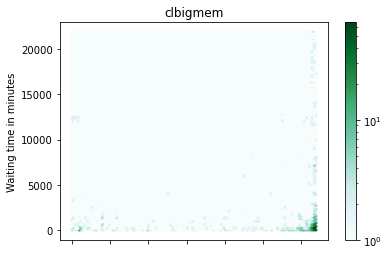

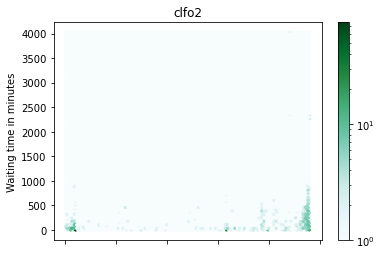

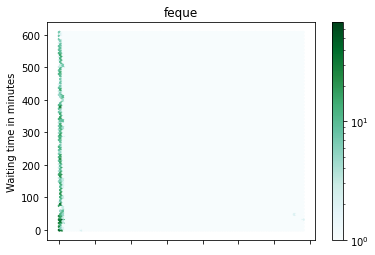

In [49]:
for batch_class in batch_classes:
    Bin_plot(jobs_waited,'CPU',batch_class)

In [42]:
80000*600000


48000000000